## Imports

In [1]:
!pip install torchsummary
import torch
import torchvision.datasets  as dsets
import torch.utils.data
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torchvision.utils as vutils
from torchsummary import summary

import tqdm
import matplotlib.pyplot as plt
import numpy as np

### Data

In [2]:
batch_size = 32
image_size = 64
num_epochs = 2
torch.cuda.set_device("cuda:0")

In [3]:
dset = dsets.ImageFolder(root="../input/",
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                           ]))
# cut the size of the dataset
dataset, _ = torch.utils.data.random_split(dset, [len(dset)//2, len(dset)-len(dset)//2])
del _
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, drop_last=True, shuffle=True)

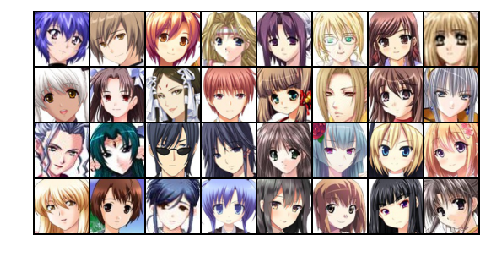

In [4]:
real_batch = next(iter(dataloader))
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0], padding=2).cpu(),(1,2,0)))

### Model

In [5]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)


class UnFlatten(nn.Module):
    def forward(self, input, size=1024):
        return input.view(input.size(0), size, 1, 1)

In [6]:
class VAE(nn.Module):
    def __init__(self, image_channels=3):
        super().__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(image_channels, 32, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2),
            nn.ReLU(),
            Flatten()
        )
        
        self.fc1 = nn.Linear(1024, 32)
        self.fc2 = nn.Linear(1024, 32)
        self.fc3 = nn.Linear(32, 1024)
        
        self.decoder = nn.Sequential(
            UnFlatten(),
            nn.ConvTranspose2d(1024, 128, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=6, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(32, image_channels, kernel_size=6, stride=2),
            nn.Sigmoid(),
        )
        
    def reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        eps = torch.randn(*mu.size())
        z = mu + std * eps
        return z
        
    def encode(self, x):
        h = self.encoder(x)
        mu = self.fc1(h)
        logvar = self.fc2(h)
        z = self.reparameterize(mu, logvar)
        return z

    def decode(self, z):
        h = self.fc3(z)
        return self.decoder(h)
    
    def forward(self, x):
        h = self.encoder(x)
        mu = self.fc1(h)
        logvar = self.fc2(h)
        z = self.reparameterize(mu, logvar)
        z = self.fc3(z)
        return self.decoder(z), mu, logvar

In [7]:
def vae_loss(recon_x, x, mu, logvar) -> float:
    BCE = F.binary_cross_entropy(recon_x.view(-1, image_size*image_size*3),
                                 x.view(-1, image_size*image_size*3), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

## training

In [8]:
model = VAE()
# summary(model, (3, 64, 64))
print(model)
try:
    model.load_state_dict(torch.load('vae.pth'))
except:
    pass
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

VAE(
  (encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2))
    (5): ReLU()
    (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2))
    (7): ReLU()
    (8): Flatten()
  )
  (fc1): Linear(in_features=1024, out_features=32, bias=True)
  (fc2): Linear(in_features=1024, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=1024, bias=True)
  (decoder): Sequential(
    (0): UnFlatten()
    (1): ConvTranspose2d(1024, 128, kernel_size=(5, 5), stride=(2, 2))
    (2): ReLU()
    (3): ConvTranspose2d(128, 64, kernel_size=(5, 5), stride=(2, 2))
    (4): ReLU()
    (5): ConvTranspose2d(64, 32, kernel_size=(6, 6), stride=(2, 2))
    (6): ReLU()
    (7): ConvTranspose2d(32, 3, kernel_size=(6, 6), stride=(2, 2))
    (8): Sigmoid()
  )
)


In [9]:
losses = []
for epoch in range(num_epochs):
    train_loss = 0
    for data, _ in tqdm.tqdm(dataloader):
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = vae_loss(recon_batch, data, mu, logvar)
        loss.backward()
        losses.append(loss.item())
        train_loss += loss.item()
        optimizer.step()
        
    torch.save(model.state_dict(), "./vae.pth")
    print('epoch %d, loss %.4f' % (epoch, train_loss / len(dataset)))
model.eval()

  0%|          | 0/993 [00:00<?, ?it/s]

epoch 0, loss 6952.2978


100%|██████████| 993/993 [05:49<00:00,  2.84it/s]

epoch 1, loss 6643.3377


VAE(
  (encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2))
    (5): ReLU()
    (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2))
    (7): ReLU()
    (8): Flatten()
  )
  (fc1): Linear(in_features=1024, out_features=32, bias=True)
  (fc2): Linear(in_features=1024, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=1024, bias=True)
  (decoder): Sequential(
    (0): UnFlatten()
    (1): ConvTranspose2d(1024, 128, kernel_size=(5, 5), stride=(2, 2))
    (2): ReLU()
    (3): ConvTranspose2d(128, 64, kernel_size=(5, 5), stride=(2, 2))
    (4): ReLU()
    (5): ConvTranspose2d(64, 32, kernel_size=(6, 6), stride=(2, 2))
    (6): ReLU()
    (7): ConvTranspose2d(32, 3, kernel_size=(6, 6), stride=(2, 2))
    (8): Sigmoid()
  )
)

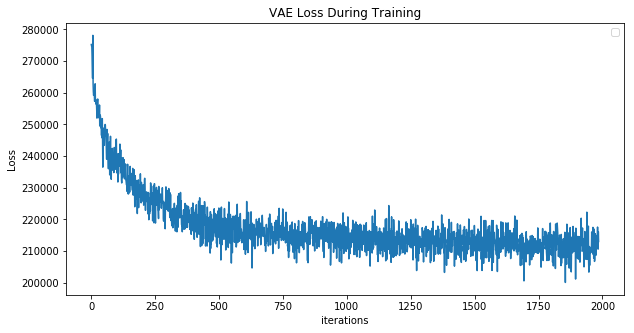

In [10]:
plt.figure(figsize=(10,5))
plt.title("VAE Loss During Training")
plt.plot(losses)
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

### Visualizations time!

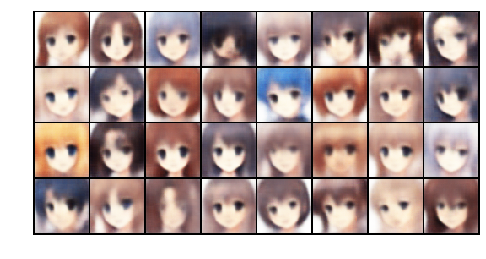

In [11]:
real_batch = next(iter(dataloader))
decoded_batch = model.decode(model.encode(real_batch[0]).data).data
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.imshow(np.transpose(vutils.make_grid(decoded_batch, padding=2).cpu(),(1,2,0)))

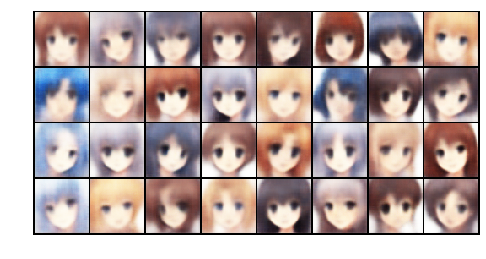

In [12]:
real_batch = next(iter(dataloader))
decoded_batch = model.decode(model.encode(real_batch[0]).data).data
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.imshow(np.transpose(vutils.make_grid(decoded_batch, padding=2).cpu(),(1,2,0)))

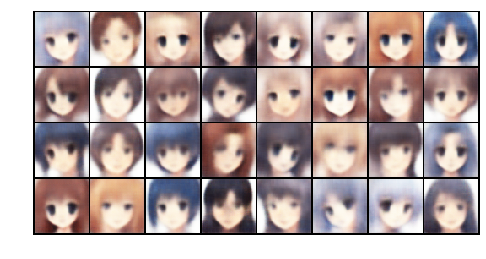

In [13]:
real_batch = next(iter(dataloader))
decoded_batch = model.decode(model.encode(real_batch[0]).data).data
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.imshow(np.transpose(vutils.make_grid(decoded_batch, padding=2).cpu(),(1,2,0)))